In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import math

In [2]:
# Get data for a given ticker
ticker = "AAPL"
data = yf.Ticker(ticker).history("10y")

In [3]:
# calculate shot and long term moving average 
short_day = 20
long_day = 100
data["SMA"] = data["Open"].rolling(window = short_day).mean()
data["LMA"] = data["Open"].rolling(window = long_day).mean()

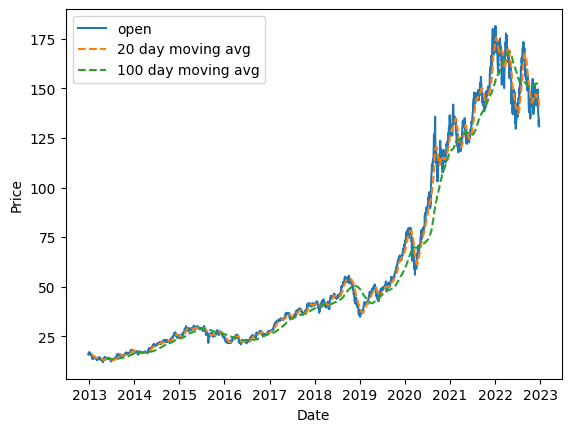

In [4]:
plt.figure()
plt.plot(data["Open"], label = "open")
plt.plot(data["SMA"], ls = '--', label = "{} day moving avg".format(short_day))
plt.plot(data["LMA"], ls = '--', label = "{} day moving avg".format(long_day))
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [18]:
# initialise position and capital
data["Position"] = 0
data["Capital"] = 1000
data["Profit"] = 0

# Simple Moving Average Crossover
We execture a simple moving average crossover strategy.  
When the SMA moves above the LMA and we aren't holding a stock we buy as much as possible.  
When the LMA moves above the SMA and we are holding a stock we sell as much as possible.  
If there is no crossover we continue doing as usual.  
We have accounted for the transaction fee as a percentage.  

In [19]:
trading_fee = 0.005 # trading fee as a percentage

# loop over days and initalise the strategy
for t, row in data.iterrows():

    # skip the first day
    if t == data.index[0]: continue

    # if short term average goes above the long term average and we arent holding a stock
    # go long
    if(row["SMA"] > row["LMA"] and data["Position"].shift(1).loc[t] == 0):
        data.loc[t, "Position"] = 1
        data.loc[t, "Capital"] = data['Capital'].shift(1).loc[t] - row['Close'] * (1 + trading_fee)
        buy = row['Close'] * (1 + trading_fee)

    # if long term average goes above the short term average and we are holding a stock
    # go short
    elif(row["LMA"] > row["SMA"] and data["Position"].shift(1).loc[t] == 1):
        data.loc[t, "Position"] = 0
        data.loc[t, "Capital"] = data['Capital'].shift(1).loc[t] + row['Close'] * (1 - trading_fee)
        sell = row['Close'] * (1 - trading_fee)
        data.loc[t, "Profit"] += sell - buy

    # no crossover so do nothing
    else:
        data.loc[t, "Position"] = data["Position"].shift(1).loc[t]
        data.loc[t, "Capital"] = data["Capital"].shift(1).loc[t]

data["cum_profit"] = data["Profit"].cumsum()

Lets plot the results of this strategy.

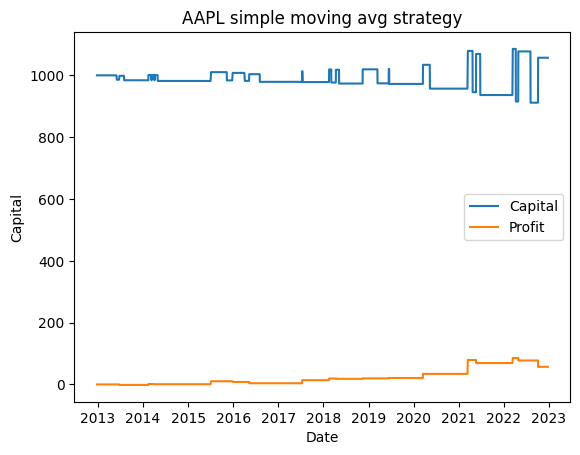

In [20]:
plt.figure()
plt.plot(data["Capital"], label = "Capital")
plt.plot(data["cum_profit"], label = "Profit")
plt.xlabel("Date")
plt.ylabel("Capital")
plt.legend()
plt.title("{} simple moving avg strategy".format(ticker))
plt.show()

This seems like a great way to lose money

## Factoring in risk
Now we look to 